# DDoS: Security metrics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#New packages installed geopandas and geoplot
import geopandas as gpd
import geoplot

In [4]:
# data source: https://surfdrive.surf.nl/files/index.php/s/CZWfWQp3VKGKa8m
df = pd.read_csv('data_with_ports.csv.gz', sep='|', compression='gzip')

C:\Users\newbi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (15,17,19,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# parse string to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y-%m-%dT%H:%M:%S+09:00')
df['stop_time'] = pd.to_datetime(df['stop_time'], format='%Y-%m-%dT%H:%M:%S+09:00')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5721432 entries, 0 to 5721431
Data columns (total 35 columns):
target_ip                 object
date                      datetime64[ns]
sensor_id                 object
service                   object
start_time                datetime64[ns]
stop_time                 datetime64[ns]
duration                  float64
packets                   int64
raw_country               object
raw_as                    object
raw_hostname              object
udp_port_list             object
pyasn_as                  float64
pyasn_as_bgp_size         float64
cc                        object
region                    object
is_oecd                   float64
as_type                   object
as_type_confidence        float64
tg_op                     object
org                       object
org_range                 object
org_rangesize             float64
org_ipsize_seen           float64
org_domainsize_seen       float64
org_ipsize_seen_shared    float

In [7]:
df.head()

,target_ip,date,sensor_id,service,start_time,stop_time,duration,packets,raw_country,raw_as,...,org_ipsize_seen_shared,org_is_hosting,org_tag,caida_type,dc,subs,as_ipsize_seen,as_domainsize_seen,pps,year
0,1.0.131.184,2014-08-02,sensor001,dns,2014-08-02 22:32:18,2014-08-02 22:37:15,297.0,609,Thailand,AS9737 TOT Public Company Limited,...,591.0,1.0,NaN,Transit/Access,0,1593000.0,405292.0,1408.0,2.050505,2014
1,1.0.131.184,2014-08-02,sensor003,dns,2014-08-02 22:32:20,2014-08-02 22:37:18,298.0,602,Thailand,AS9737 TOT Public Company Limited,...,591.0,1.0,NaN,Transit/Access,0,1593000.0,405292.0,1408.0,2.020134,2014
2,1.1.0.1,2014-07-01,sensor007,chg,2014-07-01 16:20:55,2014-07-01 16:21:24,29.0,494,China,None,...,2315.0,0.0,other,NaN,0,NaN,NaN,NaN,17.034483,2014
3,1.1.1.1,2014-01-10,sensor001,chg,2014-01-10 23:50:48,2014-01-10 23:56:46,358.0,331,Australia,AS15169 Google Inc.,...,6502.0,1.0,NaN,Content,2416,NaN,84522.0,4105765.0,0.924581,2014
4,1.1.1.1,2014-01-11,sensor001,chg,2014-01-11 01:11:09,2014-01-11 01:14:17,188.0,576,Australia,AS15169 Google Inc.,...,6502.0,1.0,NaN,Content,2416,NaN,84522.0,4105765.0,3.063830,2014


In [8]:
df.iloc[1]

target_ip                                                       1.0.131.184
date                                                    2014-08-02 00:00:00
sensor_id                                                         sensor003
service                                                                 dns
start_time                                              2014-08-02 22:32:20
stop_time                                               2014-08-02 22:37:18
duration                                                                298
packets                                                                 602
raw_country                                                        Thailand
raw_as                                    AS9737 TOT Public Company Limited
raw_hostname                             node-qg.pool-1-0.dynamic.totbb.net
udp_port_list                                                          [80]
pyasn_as                                                              23969
pyasn_as_bgp

## 0. General Overview Dataset

### a. Countries

The dataset contains 216 countries where the IP addresses reside.

In [22]:
# Countries
unique_countries = df['raw_country'].unique()
# Different results if you use unique cc -> 187
# unique_countries = df['cc'].unique()


len(unique_countries)

216

### b. Services

DNS and NTP are the major protocols that were used to execute the attack.

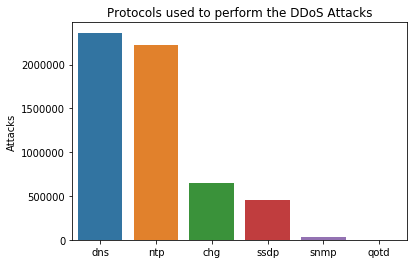

In [11]:
# Services

countServices = df["service"].value_counts()
ax = sns.barplot(countServices.index.tolist(), countServices)
ax.set_title("Protocols used to perform the DDoS Attacks")
ax.set_ylabel("Attacks")
# ax.figure.savefig("protocols.png")

plt.show()

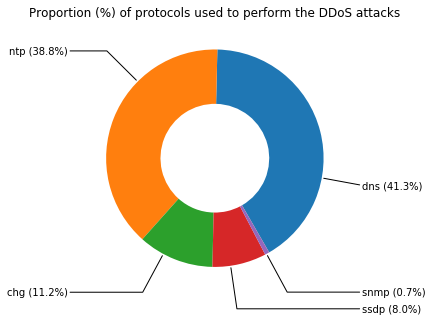

In [87]:
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw=dict(aspect="equal"))

# proportion (in percentage) of the services
pct = countServices.divide(countServices.sum()) * 100

wedges, texts = ax.pie(countServices, wedgeprops=dict(width=0.5), startangle=-60)

bbox_props = dict(boxstyle="square,pad=0.", fc="w", ec="k", lw=0.)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/3 + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
    # annotation message
    if pct[i] > 0.5:
        annotMsg = "%s (%.1f%%)" % (countServices.index.tolist()[i], pct[i])
        ax.annotate(annotMsg, xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

ax.set_title("Proportion (%) of protocols used to perform the DDoS attacks")

plt.show()

### c. as types

The type of the Autonomous System (could be ISP, Hosting, EDU, etc.)

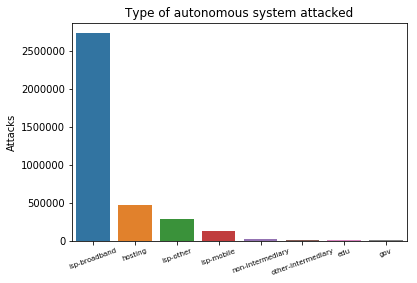

In [13]:
# AS_Types

countAsType = df["as_type"].value_counts()

ax = sns.barplot(countAsType.index.tolist(), countAsType)
ax.set_xticklabels(countAsType.index.tolist(), rotation = 20, fontsize = 7)
ax.set_title("Type of autonomous system attacked")
ax.set_ylabel("Attacks")
# ax.set_yscale('log')
ax.figure.savefig("type_as.png")

plt.show()

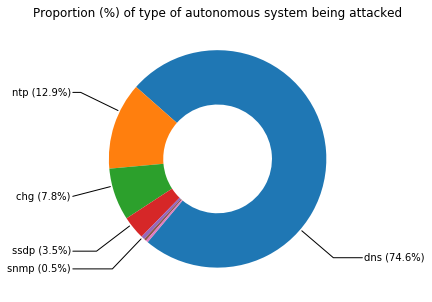

In [96]:
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw=dict(aspect="equal"))

# proportion (in percentage) of the services
pct = countAsType.divide(countAsType.sum()) * 100

wedges, texts = ax.pie(countAsType, wedgeprops=dict(width=0.5), startangle=-130)

bbox_props = dict(boxstyle="square,pad=0.", fc="w", ec="k", lw=0.)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/3 + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
    # annotation message
    if pct[i] > 0.5:
        annotMsg = "%s (%.1f%%)" % (countServices.index.tolist()[i], pct[i])
        ax.annotate(annotMsg, xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

ax.set_title("Proportion (%) of type of autonomous system being attacked")

plt.show()

### d. raw as count


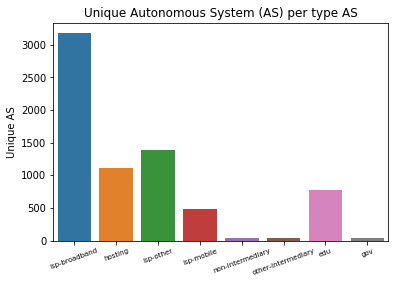

In [14]:
raw_as_count = df.drop_duplicates(["raw_as"]).groupby("as_type")["raw_as"].count()

x_raw_as = raw_as_count.index.tolist()
y_raw_as = raw_as_count
x_type = countAsType.index.tolist()
ax = sns.barplot(x_raw_as, y_raw_as, order = x_type)
ax.set_xticklabels(x_type, rotation = 20, fontsize = 7)
ax.set_title("Unique Autonomous System (AS) per type AS")
ax.set_ylabel("Unique AS")
ax.figure.savefig("type_as_unique.png")

plt.show()

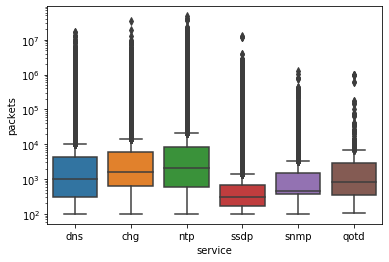

In [99]:
ax = sns.boxplot(x = "service", y = "packets", data = df)
ax.set_yscale('log')

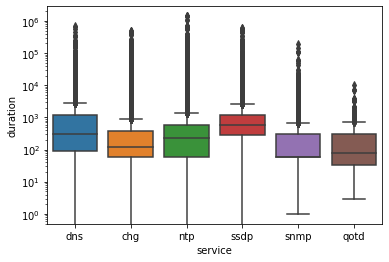

In [100]:
ax = sns.boxplot(x = "service", y = "duration", data = df)
ax.set_yscale('log')

## 1. `target_id` specific data

In [101]:
# columns where data varies among incidents
colsIncidentSpecific = ["date", "sensor_id", "service", "start_time", "stop_time", "duration", "packets", "udp_port_list", "dc", "pps"]

# columns where data is the same for specific target_id
# `org_range` is an outlier?
colsAttackerSpecific = [col for col in df.columns.to_list() if not col in colsIncidentSpecific]

In [102]:
# check target_ip="1.1.1.1" as an example
# `org_range` is different
(df.loc[df.target_ip == "1.1.1.1"].drop(columns=colsIncidentSpecific)
                                  .drop_duplicates())

,target_ip,raw_country,raw_as,raw_hostname,pyasn_as,pyasn_as_bgp_size,cc,region,is_oecd,as_type,...,org_ipsize_seen,org_domainsize_seen,org_ipsize_seen_shared,org_is_hosting,org_tag,caida_type,subs,as_ipsize_seen,as_domainsize_seen,year
3,1.1.1.1,Australia,AS15169 Google Inc.,None,15169.0,1225984.0,AU,AP,1.0,NaN,...,43506.0,1359132.0,6502.0,1.0,NaN,Content,NaN,84522.0,4105765.0,2014
1050807,1.1.1.1,Australia,AS15169 Google Inc.,None,15169.0,1225984.0,AU,AP,1.0,NaN,...,43506.0,1359132.0,6502.0,1.0,NaN,Content,NaN,84522.0,4105765.0,2015


In [103]:
# print the columns

print("\nIncident-specific columns:")
print(colsIncidentSpecific)

print("\nAttacker-specific columns:")
print(colsAttackerSpecific)


Incident-specific columns:
['date', 'sensor_id', 'service', 'start_time', 'stop_time', 'duration', 'packets', 'udp_port_list', 'dc', 'pps']

Attacker-specific columns:
['target_ip', 'raw_country', 'raw_as', 'raw_hostname', 'pyasn_as', 'pyasn_as_bgp_size', 'cc', 'region', 'is_oecd', 'as_type', 'as_type_confidence', 'tg_op', 'org', 'org_range', 'org_rangesize', 'org_ipsize_seen', 'org_domainsize_seen', 'org_ipsize_seen_shared', 'org_is_hosting', 'org_tag', 'caida_type', 'subs', 'as_ipsize_seen', 'as_domainsize_seen', 'year']


## 1. Top N Countries with most incidents

In [ ]:
# top N countries with most incidents
N = 5

# list out the top N countries with most incidents
topNcountries = df.cc.value_counts()[:N].index.to_list()

# count the daily incident frequency for each country
df_countries = df[["cc", "date"]].groupby("date").cc.value_counts().to_frame()
df_countries.columns = ["counts"]
df_countries.reset_index(inplace=True)

# filter only the top N countries
df_countries = df_countries[df_countries['cc'].isin(topNcountries)]
df_countries.columns = ["Date", "Country", "# of Incidents per day"]

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(x="Date", y="# of Incidents per day", hue="Country", data=df_countries)
ax.set_title("# of DDoS attacks per day, per country\n(top %i countries with most total # of incidents)" % N)
fig.autofmt_xdate() # formatting datetime xlabel

## 2. Sensor ID vs Service type

In [ ]:
df_sensorsAndService = df[["sensor_id", "service"]].groupby("sensor_id").service.value_counts().to_frame()
df_sensorsAndService.columns = ["counts"]
df_sensorsAndService.reset_index(inplace=True)

In [ ]:
df_sensorsAndService = df_sensorsAndService.pivot("sensor_id", "service", "counts")
df_sensorsAndService.fillna(0, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(df_sensorsAndService, annot=True, fmt=".0f", cmap="YlGnBu")
ax.set_title("# of attacks: sensor id vs service type")

## 3. Hosting Providers Analysis

In [9]:
df_host = df[df["as_type"] == "hosting"]

In [118]:
df_host[df_host["raw_country"] == "China"]

,target_ip,date,sensor_id,service,start_time,stop_time,duration,packets,raw_country,raw_as,...,org_ipsize_seen_shared,org_is_hosting,org_tag,caida_type,dc,subs,as_ipsize_seen,as_domainsize_seen,pps,year


a. map normalized for population

In [68]:
# Count the number of unique organizations in a country

host_count = df_host.drop_duplicates(["org"]).groupby("raw_country").count()['target_ip']
host_count = host_count.to_frame()

In [116]:
host_count

,target_ip
raw_country,
Argentina,6
Australia,5
Bangladesh,1
Belgium,9
Brazil,2
Bulgaria,7
Canada,38
Cyprus,1
Czech Republic,8


In [ ]:
# Load in the world dataset and country codes to merge

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countrycodes = pd.read_csv("country_code.csv", sep = ",", encoding = "utf-8")

#Merge them
host_count_cc = host_count.merge(countrycodes, left_on = "raw_country", right_on = "country", how = "left") 

In [77]:
# Merge dataset with geopandas frame. Normalize by population estimation.

world_df = world.merge(host_count_cc, left_on = "iso_a3", right_on = "country code", how = "left")
world_df["normalized_org"] = world_df["target_ip"] / world_df["pop_est"] * 100000

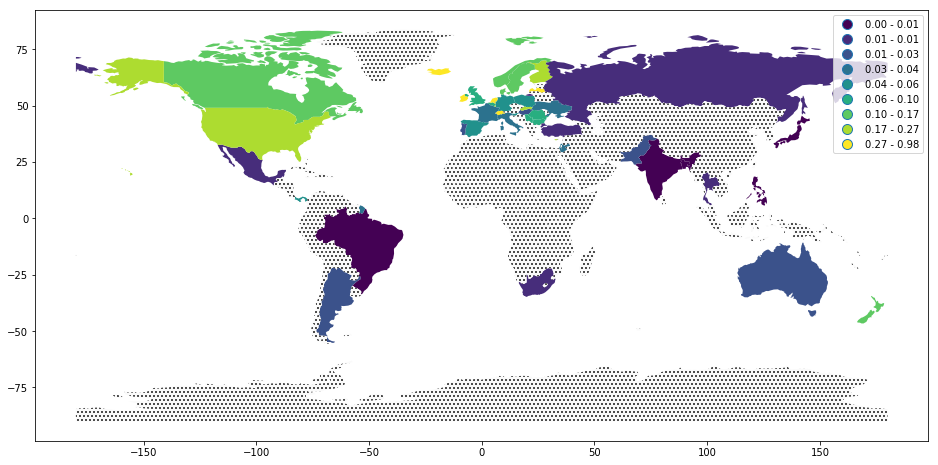

In [122]:
# Show the map, split in quantiles, show missing values. 

ax = world_df.dropna().plot(column="normalized_org", scheme='quantiles', figsize=(16, 8), k=9, legend=True)
world_df[world_df.isna().any(axis=1)].plot(ax=ax, color='#fafafa', hatch='...')
ax.figure.savefig("unique_org_world.png")